In [1]:
!pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 679.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1+cu121
    Uninstalling torch-2.3.1+cu121:
      Successfully uninstalled torch-2.3.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.1+cu121
    Uninstalling torchvision-0.18.1+cu121:
      Successfully uninstalled torchvision-0.18.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.3.1+cu121
    Uninstalling torc

In [2]:
!pip install kaolin==0.15.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.1.1_cu121.html

Looking in links: https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.1.1_cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.8/238.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.6 MB/s eta 0:00:00
  Created wheel for pygltflib: filename=pygltflib-1.16.2-py3-none-any.whl size=27300 sha256=30bb7ebcf18a36cf48ddf91c5a2fea2911e4cec210bf05f390ca4f62ee98aff2
  Stored in directory: /root/.cache/pip/wheels/4a/95/a2/2ee16c602170b0601ebeddbf06597868f09b7dbb0495ae99c4
Successfully built pygltflib


In [3]:
import kaolin
print(kaolin.__version__)

0.15.0


In [4]:
#improter

import random
import os
import re
import sys
import json
import time
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [5]:
#connect to GoogleDrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#dataset_download

def extract(filename):
    #zip_path = f'/content/other_drive/MyDrive/dataset_2d_to_point_clouds/{filename}'
    zip_path = f'/content/drive/MyDrive/dataset_2d_to_point_clouds/{filename}'
    extract_path = '/content/extracted_files'
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    extracted_files = os.listdir(extract_path)
    print(extracted_files)

#print(os.listdir('/content/extracted_files/ShapeNet_pointclouds/02691156/1a04e3eab45ca15dd86060f189eb133'))

In [7]:
#unzipping dataset

#extract('ShapeNetRendering.zip')
extract('ShapeNet_pointclouds.zip')
extract('splits.zip')

['ShapeNet_pointclouds']
['ShapeNet_pointclouds', 'splits']


In [8]:
print(os.listdir('/content/extracted_files/ShapeNet_pointclouds/02691156/1a04e3eab45ca15dd86060f189eb133'))

['pointcloud_2048.npy', 'pointcloud_1024.npy']


In [11]:
#BatchGen for DenceNet, (point cloud(1024 points) --- point cloud(2048 points))

shapenet_id_to_category = {
'02691156': 'airplane',
'02828884': 'bench',
'02933112': 'cabinet',
'02958343': 'car',
'03001627': 'chair',
'03211117': 'monitor',
'03636649': 'lamp',
'03691459': 'speaker',
'04090263': 'rifle',
'04256520': 'sofa',
'04379243': 'table',
'04401088': 'telephone',
'04530566': 'vessel'
}

shapenet_category_to_id = {
'airplane'	: '02691156',
'bench'		: '02828884',
'cabinet'	: '02933112',
'car'		: '02958343',
'chair'		: '03001627',
'lamp'		: '03636649',
'monitor'	: '03211117',
'rifle'		: '04090263',
'sofa'		: '04256520',
'speaker'	: '03691459',
'table'		: '04379243',
'telephone'	: '04401088',
'vessel'	: '04530566'
}

class BatchGen_DenceNet:

    def __init__(self, json_path, dots_directory):
        self.labels = []
        cats = shapenet_id_to_category.keys()

        with open(json_path, 'r') as f:
            train_models_dict = json.load(f)

        for cat in cats:
            self.labels.extend([model for model in train_models_dict[cat]])

        self.dots_directory = dots_directory

    def __len__(self):
        return len(self.labels)

    def transform_dots(self, dots):
        shape = dots.shape[0]

        if shape <= self.dots_size:

            for i in range(self.dots_size - shape):
                dots = pd.concat([dots, pd.DataFrame({'x': [0], 'y': [0], 'z':[0]})])
        else:
            indexes = np.random.choice(shape, shape - self.dots_size, replace=False)
            dots = dots.drop(indexes)

        return dots

    def normilize_dots(self, points):
        points -= np.min(points)
        points /= np.max(points)
        return points

    def __getitem__(self, index):
        label = self.labels[index]
        dots_path1 = os.path.join(self.dots_directory, os.path.join(label, 'pointcloud_1024.npy'))
        dots_path2 = os.path.join(self.dots_directory, os.path.join(label, 'pointcloud_2048.npy'))

        dots1 = np.load(dots_path1)
        dots2 = np.load(dots_path2)

        dots1 = self.normilize_dots(dots1)
        dots2 = self.normilize_dots(dots2)

        dots1 = torch.from_numpy(dots1).float()
        dots2 = torch.from_numpy(dots2).float()
        return dots1, dots2

In [12]:
# func for extracting local features

# This function finds 'num_near_points' nearest points for a given point. This will be used for extracting local point features.
# If there are less then 'num_near_points' points inside a circle of radius=radius, returned ndarray will be filled with [0, 0, 0];
# it will contain [0, 0, 0] * (num_near_points - num of points inside circle) times.

def get_nearest_points(pcl, radius=0.5, num_near_points=10):
    points = None
    for step, pcl_i in enumerate(pcl):
        nbrs = NearestNeighbors(n_neighbors=num_near_points, radius=radius, algorithm='auto').fit(pcl_i)
        distances, indices = nbrs.radius_neighbors(pcl_i)
        n = pcl_i.shape[0]
        nearest_points_all = np.zeros((n, num_near_points, 3))
        for i in range(n):
            nearest_points_within_radius = pcl_i[indices[i]]
            if len(nearest_points_within_radius) >= num_near_points:
                sorted_indices = np.argsort(distances[i])[:num_near_points]
                nearest_points_all[i] = nearest_points_within_radius[sorted_indices]
            else:
                nearest_points_all[i, :len(nearest_points_within_radius)] = nearest_points_within_radius

        nearest_points_all = np.expand_dims(nearest_points_all, axis=0)

        if step == 0:
            points = nearest_points_all
        else:

            points = np.concatenate((points, nearest_points_all), axis=0)

    return points

def concatenate_with_pcl(pcl, nearest_points_all):
    nearest_points_all_torch = torch.tensor(nearest_points_all, dtype=torch.float32).to('cuda')
    nearest_points_all_flattened = nearest_points_all_torch.view(nearest_points_all_torch.shape[0], nearest_points_all_torch.shape[1], -1)
    result = torch.cat((pcl, nearest_points_all_flattened), dim=2)
    return result

In [13]:
#DenceNet

class RadiusEncoder(nn.Module):
    def __init__(self, input_size, n_filters=[32, 128, 512, 1024, 512, 128, 64]): #n_filters[-1], (n/2**n_filters >= 1)
        super().__init__()
        n_layers = len(n_filters)
        self.dropouts = nn.ModuleList([nn.Dropout(0.3) for i in range(n_layers)])
        self.encoder = nn.ModuleList(
            [nn.Conv1d(input_size, n_filters[i], 3, padding=1) if i == 0 else nn.Conv1d(n_filters[i - 1], n_filters[i], 3, padding=1) #k, k-1//2  padding = (kernel_size-1)/2
             for i in range(n_layers)])
        self.pools = nn.ModuleList([nn.MaxPool1d(2) for i in range(n_layers)])

    def forward(self, x):
        n = x.shape[2]
        for conv, drop in zip(self.encoder, self.dropouts):
            x = conv(x)
            x = drop(x)
            x = F.relu(x)
        return x


class Encoder(nn.Module):
    def __init__(self, input_size, n_filters=[32, 128, 512, 1024, 512, 128, 64]): #n_filters[-1], (n/2**n_filters >= 1)
        super().__init__()
        n_layers = len(n_filters)
        self.dropouts = nn.ModuleList([nn.Dropout(0.3) for i in range(n_layers)])
        self.encoder = nn.ModuleList(
            [nn.Conv1d(input_size, n_filters[i], 3, padding=1) if i == 0 else nn.Conv1d(n_filters[i - 1], n_filters[i], 3, padding=1) #k, k-1//2  padding = (kernel_size-1)/2
             for i in range(n_layers)])
        self.pools = nn.ModuleList([nn.MaxPool1d(2) for i in range(n_layers)])

    def forward(self, x):
        n = x.shape[2]
        for conv, pool, drop in zip(self.encoder, self.pools, self.dropouts):
            x = conv(x)
            x = drop(x)
            x = pool(x)
            x = F.relu(x)
        x = torch.mean(x, dim=2)
        return x


class Decoder(nn.Module):
    def __init__(self, input_size, layer_sizes=[512, 1024, 2048, 1024, 512, 3]):
        super().__init__()
        n_layers = len(layer_sizes)
        self.decoder = nn.ModuleList()
        for i in range(n_layers - 1):
            if i == 0:
                self.decoder.append(nn.Conv1d(input_size, layer_sizes[i], 2, stride=2))
            else:
                self.decoder.append(nn.Conv1d(layer_sizes[i - 1], layer_sizes[i], 2, stride=2))

            self.decoder.append(nn.ConvTranspose1d(layer_sizes[i], layer_sizes[i], 2, stride=2))
            self.decoder.append(nn.ReLU())

        self.out = nn.Conv1d(layer_sizes[-2], layer_sizes[-1], 1)

    def forward(self, x):
        for layer in self.decoder:
            x = layer(x)
        x = self.out(x)
        return x


class DenseNet(nn.Module):
    def __init__(self, input_size, upsampling_factor): #upsampling_factor=2, num_radius_points=10
        super(DenseNet, self).__init__()
        self.upsampling_factor = upsampling_factor
        self.encoder = Encoder(input_size)
        self.radius_encoder = RadiusEncoder(input_size + 3 * 10)
        self.decoder = Decoder(131 + 128)

    def forward(self, pcl):
        batch_size = pcl.shape[0]
        n = pcl.shape[1]

        z = self.encoder(pcl.permute(0, 2, 1))
        #print('z: ', z.shape)
        #print('pcl_in: ', pcl.shape)

        point_feat = pcl.unsqueeze(2).expand(-1, -1, self.upsampling_factor, -1)  # (bs,NUM_POINTS,3) --> (bs,NUM_POINTS,1,3) --> (bs,NUM_POINTS,2,3)
        point_feat = point_feat.reshape(batch_size, -1, 3)  # (bs,NUM_POINTS,2,3) --> (bs,NUM_UPSAMPLE_POINTS,3)
        #print('point_feat: ', point_feat.shape)  # 'point_feat: ', point_feat.shape

        global_feat = z.unsqueeze(1).expand(-1, self.upsampling_factor*n, -1)  # (bs,bneck) --> (bs,1,bneck) --> (bs,NUM_UPSAMPLE_POINTS,bneck)
        #print('global_feat: ', global_feat.shape)  # 'global_feat: ', global_feat.shape
        concat_feat = torch.cat([point_feat, global_feat], dim=2).permute(0, 2, 1)
        #print('concat_feat1: ', concat_feat.shape)
        # adding local point features (3 circles)

        for i in range(3):
            near_points = get_nearest_points(pcl.cpu(), radius=0.03 + i/100, num_near_points=10)
            data = concatenate_with_pcl(pcl, near_points)
            data = data.transpose(1, 2)
            local_feat = self.radius_encoder(data)
            local_feat = local_feat.unsqueeze(2).repeat(1, 1, self.upsampling_factor, 1)  # (bs, NUM_POINTS, 1, 64) --> (bs, NUM_POINTS, 4, 64)
            local_feat = local_feat.view(batch_size, self.upsampling_factor*n, -1)  # (bs, NUM_POINTS, 4, 64) --> (bs, NUM_UPSAMPLE_POINTS, 64)
            #print("concat_feat", concat_feat.shape)
            #print("local_feat", local_feat.shape)
            local_feat = torch.transpose(local_feat, 1, 2)

            concat_feat = torch.cat([concat_feat, local_feat], dim=1)

        #print('concat_feat2: ', concat_feat.shape)
        dense = self.decoder(concat_feat)
        #print('dense1: ', dense.shape)
        dense = dense.view(batch_size, -1, 3)  # Reshape to (bs,NUM_UPSAMPLE_POINTS,3)
        #print('dense2: ', dense.shape)

        return dense


    def predict(self, x, upsample=2):
        for _ in range(upsample):
            x = self.forward(x)
        return x # [batch_size, N, 3] -> [batch_size, N * 2^upsample, 3]

In [14]:
def point_loss(points):
    loss = torch.empty(points.shape[0], dtype=torch.float)
    loss = loss.to('cuda')
    for i in range(points.shape[0]):
        dist = torch.cdist(points[i], points[i])
        dist = dist[(dist <= 0.01) & (dist >= 0.00001)]
        dist = 0.002 / dist
        loss[i] = dist.mean()
    loss = min(1.0, loss.mean() / 5.0)
    return loss

In [15]:
def val(model, valid_generator, num_examples):
    model.eval()
    metric = torch.tensor([0.0])
    metric = metric.to('cuda')

    with torch.no_grad():
        for pcl1, pcl2 in valid_generator:
            pcl1 = pcl1.to('cuda').unsqueeze(0)
            pcl2 = pcl2.to('cuda').unsqueeze(0)
            pcl1 = pcl1.view(-1, 1024, 3)
            pcl2 = pcl2.view(-1, 2048, 3)
            out = model(pcl1)
            out = out.reshape(-1, 2048, 3)
            metric += torch.sum(kaolin.metrics.pointcloud.f_score(out, pcl2)) / num_examples

    return metric

In [ ]:
#DenseNet train
save_dir = 'model'
save_nums_dir = 'nums'

upsampling_factor = 2
input_size = 3

pcl_path = 'ShapeNet_pointclouds/ShapeNet_pointclouds'
json_path = 'splits/splits/train_models.json'

val_pcl_path = 'ShapeNet_pointclouds/ShapeNet_pointclouds'
val_json_path = 'splits/splits/val_models.json'

params_train = {'batch_size': 32, 'shuffle': True}
params_val = {'batch_size': 64, 'shuffle': False}

training_set = BatchGen_DenceNet(json_path, pcl_path)
valid_set = BatchGen_DenceNet(val_json_path, val_pcl_path)
training_generator = torch.utils.data.DataLoader(training_set, **params_train)
valid_generator = torch.utils.data.DataLoader(valid_set, **params_val)

densenet = DenseNet(input_size, upsampling_factor)
densenet = densenet.to('cuda')

optim = torch.optim.Adam(densenet.parameters(), lr=1e-4)
points_loss_val = 0.001
counter_ep = 1
counter = 0

loss_list = []
val_list = []
loss_dict = {}
val_dict = {}

for i in range(12):
    print(f"{counter_ep} epoch")
    for data, target in training_generator:
        counter += 1
        print(counter)
        optim.zero_grad()
        data = data.to('cuda')
        target = target.to('cuda')
        out = densenet(data)
        out = out.reshape(-1, 2048, 3)
        target = target.view(-1, 2048, 3)
        #print(out)
        loss = kaolin.metrics.pointcloud.chamfer_distance(out, target)
        loss = torch.mean(loss) + points_loss_val * point_loss(out)
        if counter % 100 == 0:
            print(counter, loss.item())
            #loss_list.append(loss.item())
            loss_dict[counter] = loss.item()

        loss.backward()
        optim.step()

    score = val(densenet, valid_generator, len(valid_generator))
    print(f"epoch = {counter_ep}, score =", score.item())
    #val_list.append(score.item())
    val_dict[counter_ep] = score.item()
    torch.save(densenet.state_dict(), os.path.join(save_dir, f'densenet_{counter_ep}_epoch.pt'))

    densenet.train()
    counter_ep += 1

print("end of learning")
torch.save(densenet.state_dict(), 'densenet.pt')

with open(os.path.join(save_nums, 'loss'), 'wb') as f:
    pickle.dump(loss_dict, f)
with open(os.path.join(save_nums, 'val'), 'wb') as f:
    pickle.dump(loss_dict, f)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [28]:
pcl_path = '/content/extracted_files/ShapeNet_pointclouds'
json_path = '/content/extracted_files/splits/train_models.json'

val_pcl_path = '/content/extracted_files/ShapeNet_pointclouds'
val_json_path = '/content/extracted_files/splits/val_models.json'

params_train = {'batch_size': 32, 'shuffle': True}
params_val = {'batch_size': 64, 'shuffle': False}

training_set = BatchGen_DenceNet(json_path, pcl_path)
valid_set = BatchGen_DenceNet(val_json_path, val_pcl_path)
training_generator = torch.utils.data.DataLoader(training_set, **params_train)
valid_generator = torch.utils.data.DataLoader(valid_set, **params_val)

In [42]:
densenet = DenseNet(3, 2)
densenet.to('cuda')
densenet.load_state_dict(torch.load('/content/densenet_9_epoch.pt'))

<All keys matched successfully>

torch.Size([64, 3, 1024])
predicted_data.shape: torch.Size([64, 4096, 3])


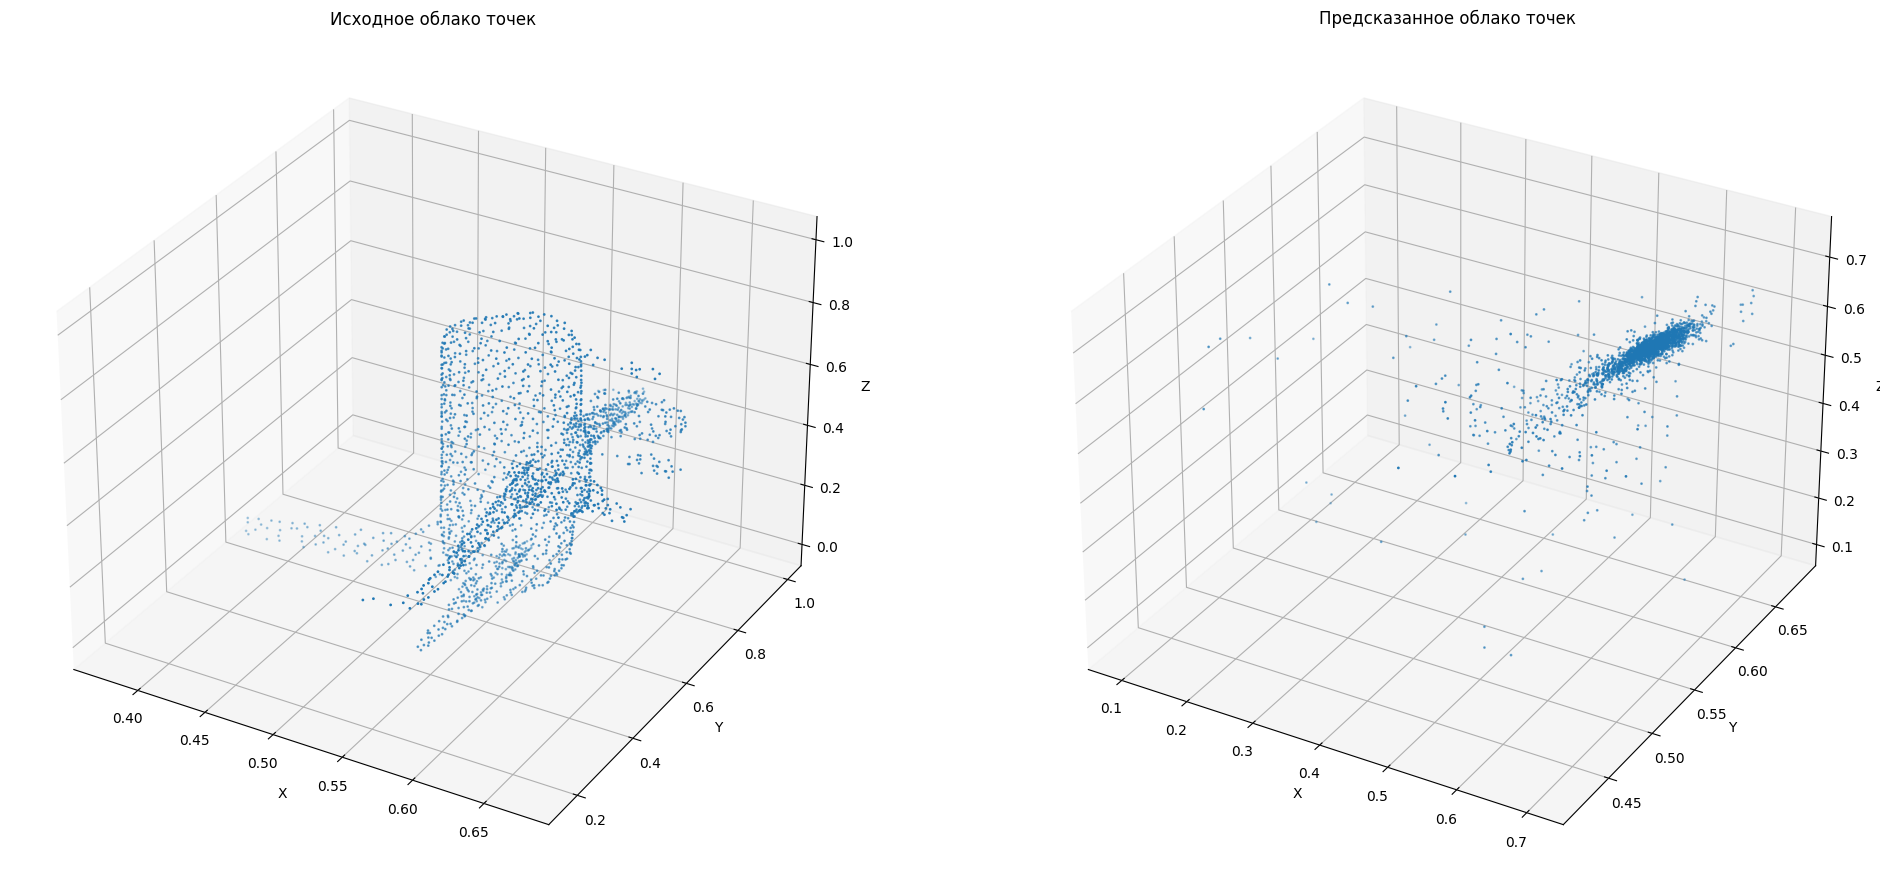

In [49]:
#checking prediction

#data_iter = iter(valid_generator)

data1, data2 = next(data_iter)
data1 = data1.to('cuda')
data1_transposed = torch.transpose(data1, 1, 2)

with torch.no_grad():
    print(data1_transposed.shape)
    predicted_data = densenet.predict(data1, 2)
    print("predicted_data.shape:", predicted_data.shape)

predicted_data = predicted_data.view(-1, 2048, 4).cpu().numpy()

points2 = data2.cpu().numpy()


fig = plt.figure(figsize=(24, 12))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points2[0, :, 0], points2[0, :, 1], points2[0, :, 2], s=1)
ax1.set_title('Исходное облако точек')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(122, projection='3d')
predicted_points = predicted_data[0]
ax2.scatter(predicted_points[:, 0], predicted_points[:, 1], predicted_points[:, 2], s=1)
ax2.set_title('Предсказанное облако точек')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

In [44]:
import pickle

with open('/content/loss', 'rb') as f:
    loss_dict = pickle.load(f)

with open('/content/val', 'rb') as f:
    val_dict = pickle.load(f)

print(loss_dict)
print(val_dict)

{100: 0.026651564985513687, 200: 0.01696298085153103, 300: 0.016958367079496384, 400: 0.013215829618275166, 500: 0.01670669950544834, 600: 0.013425260782241821, 700: 0.012476393952965736, 800: 0.013794612139463425, 900: 0.013044007122516632, 1000: 0.012803995981812477, 1100: 0.013369757682085037, 1200: 0.011671719141304493, 1300: 0.01417530607432127, 1400: 0.012108406983315945, 1500: 0.014929129742085934, 1600: 0.015820739790797234, 1700: 0.012101837433874607, 1800: 0.011907573789358139, 1900: 0.014442486688494682, 2000: 0.012229010462760925, 2100: 0.012182386592030525, 2200: 0.013086182996630669, 2300: 0.014396164566278458, 2400: 0.011357564479112625, 2500: 0.014019530266523361, 2600: 0.014607965014874935, 2700: 0.011491185054183006, 2800: 0.010421239770948887, 2900: 0.01161997951567173, 3000: 0.010631654411554337, 3100: 0.011007324792444706, 3200: 0.011576096527278423, 3300: 0.011220328509807587, 3400: 0.014798616990447044, 3500: 0.012684670276939869, 3600: 0.012396829202771187, 3700

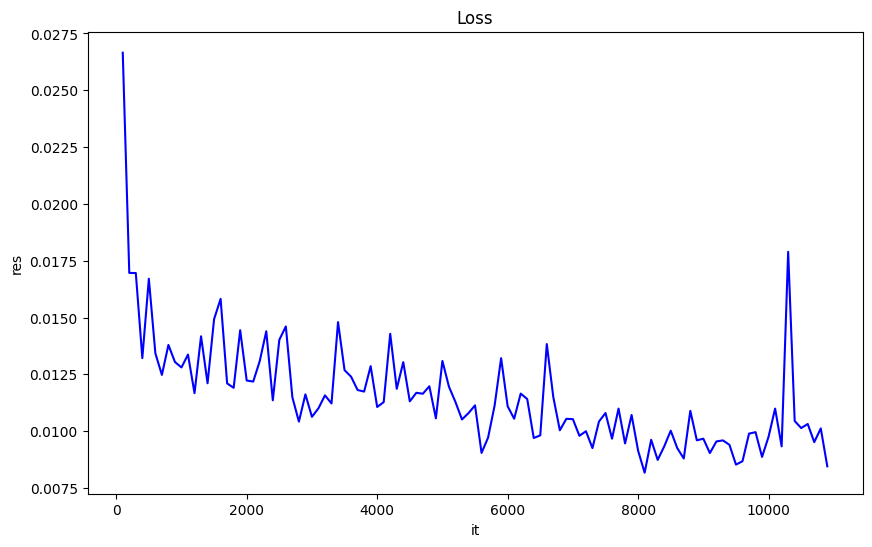

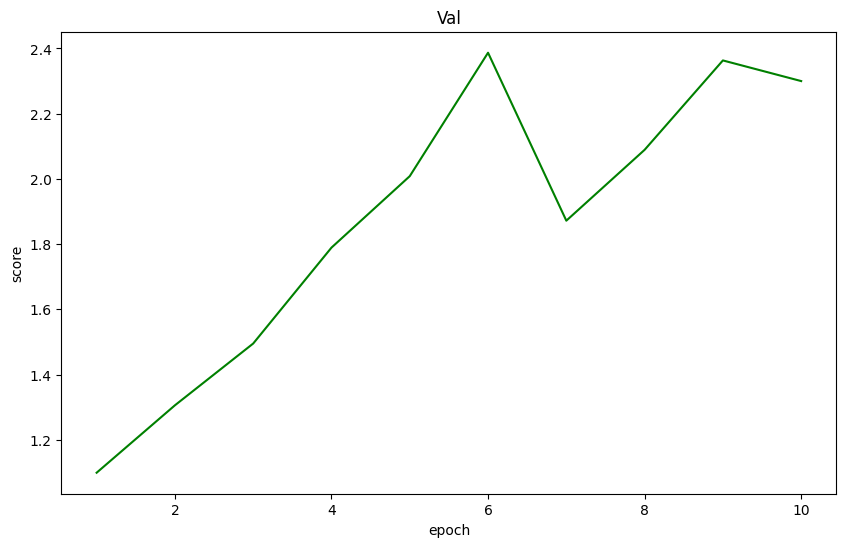

In [36]:
x1 = list(loss_dict.keys())
y1 = list(loss_dict.values())
plt.figure(figsize=(10, 6))
plt.plot(x1, y1, color='blue')
plt.xlabel('it')
plt.ylabel('res')
plt.title('Loss')
plt.show()

x2 = list(val_dict.keys())
y2 = list(val_dict.values())
plt.figure(figsize=(10, 6))
plt.plot(x2, y2, color='green')
plt.xlabel('epoch')
plt.ylabel('score')
plt.title('Val')
plt.show()